In [1]:
!pip install surprise

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 10.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp311-cp311-linux_x86_64.whl size=1199980 sha256=d0fba5c2393e89955af179dd3020d3e7d53658ba1d14d7dc9b884ba5af4dc095
  Stored in directory: /home/hshah78/.cache/pip/wheels/f4/2b/26/e2a5eae55d3b7688995e66abe7f40473aac6c95ddd8ee174a8
Successfully built scikit-surprise


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import accuracy
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import KFold
from surprise import CoClustering
from collections import deque
import random
import pickle

In [3]:
import torch

if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))


else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 3 GPU(s) available.
We will use the GPU: NVIDIA A30


In [4]:
movie_titles = pd.read_csv('movie_titles.csv', encoding = 'ISO-8859-1', header = None, names = ['Id', 'Year', 'Name']).set_index('Id')

In [59]:
movie_titles

,Year,Name
Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
...,...,...
17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17767,2004.0,Fidel Castro: American Experience
17768,2000.0,Epoch


In [103]:
df_1 = pd.read_csv('combined_data_1.txt', header=None, names=['Cust_Id', 'Rating'], usecols=[0, 1], low_memory=False)
df_2 = pd.read_csv('combined_data_2.txt', header=None, names=['Cust_Id', 'Rating'], usecols=[0, 1], low_memory=False)
df_3 = pd.read_csv('combined_data_3.txt', header=None, names=['Cust_Id', 'Rating'], usecols=[0, 1], low_memory=False)
df_4 = pd.read_csv('combined_data_4.txt', header=None, names=['Cust_Id', 'Rating'], usecols=[0, 1], low_memory=False)

frames = [df_1, df_2, df_3, df_4]
merged_df = pd.concat(frames)
merged_df['Rating'] = merged_df['Rating'].astype(float)


merged_df.index = np.arange(0, len(merged_df))
merged_df = merged_df[1:len(merged_df)]
tmp_movies = merged_df[merged_df['Rating'].isna()]['Cust_Id'].reset_index()
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]
shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)

user_data = []
for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
    if df_id_1 < df_id_2:
        tmp_df = merged_df.loc[df_id_1 + 1: df_id_2 - 1].copy()
    else:
        tmp_df = merged_df.loc[df_id_1 + 1:].copy()
    tmp_df['Movie'] = movie_id
    user_data.append(tmp_df)
rating = pd.concat(user_data)
print('Shape Cust_Id-Ratings:\t{}'.format(rating.shape))
rating.sample(5)

Shape Cust_Id-Ratings:	(100479960, 3)


,Cust_Id,Rating,Movie
8006904,332079,5.0,1604
55451882,985637,3.0,10143
7063076,206698,5.0,1409
89794048,2497967,3.0,15953
78189961,2387672,5.0,14214


In [104]:
ratings = rating[['Cust_Id','Movie','Rating']]
ratings.columns = ['userId','movieId','rating']
ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}

df = pd.DataFrame(ratings_dict)
df.shape

(100479960, 3)

In [105]:
from collections import Counter

customers = df.userID
ratings_count = Counter(customers)

In [106]:
lower = 10
upper = 400

ratings_count = df['userID'].value_counts()
valid_customers = ratings_count[(ratings_count >= lower) & (ratings_count <= upper)].index

df = df[df['userID'].isin(valid_customers)]

In [107]:
ratings_count_edit = df['userID'].value_counts().to_dict()

In [108]:
ratings_count = df['itemID'].value_counts().to_dict()

<Axes: ylabel='Count'>

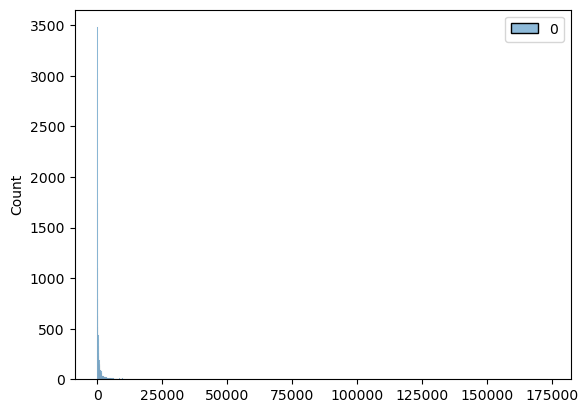

In [109]:
sns.histplot(ratings_count.values())

In [111]:
ratings_count = df['itemID'].value_counts()

lower_limit = 10
upper_limit = 10000
valid_items = ratings_count[(ratings_count >= lower_limit) & (ratings_count <= upper_limit)].index

df = df[df['itemID'].isin(valid_items)]

In [112]:
ratings_count_edit = df['itemID'].value_counts().to_dict()

<Axes: ylabel='Count'>

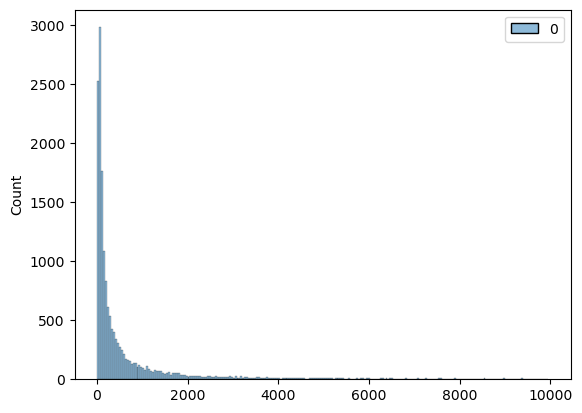

In [113]:
sns.histplot(ratings_count_edit.values())

In [114]:
average_rating = df.groupby('itemID').mean(numeric_only = True)['rating'].round(2)
rating_frequency = df.groupby('itemID').count()['rating']
popularity_model = pd.DataFrame({'average_rating':average_rating,'rating_frequency':rating_frequency})
popularity_model = popularity_model.sort_values(by = ['average_rating', 'rating_frequency'], ascending = [False, False])
popularity_model.head()

,average_rating,rating_frequency
itemID,,
8964,5.00,10
14791,4.86,35
5684,4.78,27
12398,4.74,491
3033,4.74,99


In [130]:
def get_top_movies(final_rating, number_of_movies, min_avg_rating, min_play_freq):
    filtered_ratings = final_rating[
        (final_rating['average_rating'] > min_avg_rating) & 
        (final_rating['rating_frequency'] > min_play_freq)
    ]
    sorted_ratings = filtered_ratings.sort_values(by=['average_rating', 'rating_frequency'], ascending=[False, False])
    top_movie_ids = sorted_ratings.index[:number_of_movies]
    movie_id_to_title = movie_titles['Name'].to_dict()
    top_movies = [(movie_id, movie_id_to_title[movie_id]) for movie_id in top_movie_ids]
    return top_movies

recommendations = get_top_movies(popularity_model, 10, 4, 600)
get_movie_names(recommendations)

[(3456, 'Lost: Season 1', 'Lost: Season 1'),
 (15538, 'Fullmetal Alchemist   ', 'Fullmetal Alchemist   '),
 (9864, 'Battlestar Galactica: Season 1', 'Battlestar Galactica: Season 1'),
 (7833, 'Arrested Development: Season 2', 'Arrested Development: Season 2'),
 (13504, 'House M.D.: Season 1', 'House M.D.: Season 1'),
 (4238, 'Inu-Yasha   ', 'Inu-Yasha   '),
 (10644, 'The West Wing: Season 4', 'The West Wing: Season 4'),
 (12834, 'Family Guy: Vol. 2: Season 3', 'Family Guy: Vol. 2: Season 3'),
 (4427, 'The West Wing: Season 3', 'The West Wing: Season 3'),
 (2102, 'The Simpsons: Season 6', 'The Simpsons: Season 6')]

In [131]:
reader = Reader(rating_scale = (0,5))
data = Dataset.load_from_df(df[["userID", "itemID", "rating"]], reader)

In [132]:
trainset = data.build_full_trainset()

In [133]:
sim_options = {'name': 'cosine', 'user_based':False}

sim_user_user = KNNBasic(sim_options=sim_options, random_state=1)
sim_user_user.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [39]:
filename = 'user_user_model.pkl'
pickle.dump(sim_user_user, open(filename, 'wb'))

In [140]:
def get_recommendations(data, user_id, top_n, algo):
    recommendations = []
    user_item_interactions_matrix = data.pivot_table(index='userID', columns='itemID', values='rating')
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    for item_id in non_interacted_products:
        est = algo.predict(user_id, item_id).est
        recommendations.append((item_id, est))
    recommendations.sort(key=lambda x: x[1], reverse=True)
    return recommendations[:top_n]

In [141]:
def get_movie_names(recommendations):
    item_id_to_title = movie_titles['Name'].to_dict()
    recommended_movies = [(item_id, item_id_to_title[item_id], rating) for item_id, rating in recommendations]
    return recommended_movies

In [142]:
random_user = random.choice(list(df.userID))
random_item = random.choice(list(df.itemID))

recommendations = get_recommendations(df, str(random_user), 10, sim_user_user)
print(recommendations)

[(616, 4.909037647524437), (3435, 4.82212460423533), (15521, 4.777777777777778), (14232, 4.716017633529244), (12955, 4.694387478924723), (2948, 4.670267332830878), (13637, 4.6645251861308115), (1953, 4.663269588602865), (15142, 4.658141615106851), (11033, 4.654508497187474)]


In [143]:
def rank_items_based_on_recommendations(recommendations, final_ratings):
    recommended_items = [item[0] for item in recommendations]
    ranked_items = final_ratings.loc[recommended_items].sort_values('rating_frequency', ascending=False)[['rating_frequency']].reset_index()
    
    recommendations_df = pd.DataFrame(recommendations, columns=['itemID', 'predicted_ratings'])
    ranked_items = ranked_items.merge(recommendations_df, on='itemID', how='inner')
    
    ranked_items['corrected_ratings'] = ranked_items['predicted_ratings'] - 1 / np.sqrt(ranked_items['rating_frequency'])
    ranked_items = ranked_items.sort_values('corrected_ratings', ascending=False)
    
    return ranked_items

In [144]:
rankings_sim_sim_user = rank_items_based_on_recommendations(recommendations, popularity_model)

In [145]:
rankings_sim_sim_user

,itemID,rating_frequency,predicted_ratings,corrected_ratings
8,616,16,4.909038,4.659038
4,3435,24,4.822125,4.618000
1,15521,33,4.777778,4.603700
0,15142,41,4.658142,4.501968
7,14232,21,4.716018,4.497800
3,12955,25,4.694387,4.494387
2,13637,26,4.664525,4.468409
5,2948,22,4.670267,4.457067
6,1953,22,4.663270,4.450069
9,11033,10,4.654508,4.338281


In [146]:
get_movie_names(recommendations)

[(616, 'SCTV Network 90: Vol. 4', 4.909037647524437),
 (3435, 'The House of Seven Corpses   ', 4.82212460423533),
 (15521, 'Without Conscience   ', 4.777777777777778),
 (14232, 'Act of War   ', 4.716017633529244),
 (12955, 'The Perfect Wife   ', 4.694387478924723),
 (2948, 'Razor Blade Smile   ', 4.670267332830878),
 (13637, 'Angel of the Night   ', 4.6645251861308115),
 (1953, 'B.U.S.T.E.D.   ', 4.663269588602865),
 (15142, 'Times Square   ', 4.658141615106851),
 (11033, 'Bloodfist 4: Die Trying', 4.654508497187474)]

In [154]:
svd = SVD()
svd.fit(trainset)

In [155]:
filename = 'svd_model.pkl'
pickle.dump(svd, open(filename, 'wb'))

In [156]:
svd.predict(random_user, random_item)

Prediction(uid='2075580', iid=330, r_ui=None, est=3.4328682601839304, details={'was_impossible': False})

In [157]:
recommendations = get_recommendations(df, str(random_user), 10, svd)
print(recommendations)

[(8197, 5), (10809, 5), (11191, 5), (12371, 5), (15437, 5), (7914, 4.957626024640009), (10418, 4.944059423410189), (14808, 4.941031323022211), (10883, 4.922892351254339), (5714, 4.913208774913886)]


In [158]:
rankings_svd = rank_items_based_on_recommendations(recommendations, popularity_model)
rankings_svd

,itemID,rating_frequency,predicted_ratings,corrected_ratings
0,8197,6720,5.000000,4.987801
2,10809,5858,5.000000,4.986935
3,11191,4840,5.000000,4.985626
5,15437,1195,5.000000,4.971072
9,12371,557,5.000000,4.957629
4,7914,1495,4.957626,4.931763
1,10418,5942,4.944059,4.931087
8,14808,597,4.941031,4.900104
6,10883,935,4.922892,4.890189
7,5714,757,4.913209,4.876863


In [159]:
get_movie_names(recommendations)

[(8197, 'Deadwood: Season 1', 5),
 (10809, 'Four Rooms   ', 5),
 (11191, 'South Park: Season 3', 5),
 (12371, 'South Park: Timmy!   ', 5),
 (15437, 'South Park: Season 6', 5),
 (7914, 'MI-5: Vol. 1', 4.957626024640009),
 (10418, 'South Park: Season 1', 4.944059423410189),
 (14808, 'Viva La Bam: Seasons 2 and 3', 4.941031323022211),
 (10883, 'The Titanic   ', 4.922892351254339),
 (5714, 'Upstairs Downstairs: Season 4', 4.913208774913886)]

In [160]:
CoCluster = CoClustering()
CoCluster.fit(trainset)

In [161]:
filename = 'cocluster_model.pkl'
pickle.dump(CoCluster, open(filename, 'wb'))

In [162]:
CoCluster.predict(random_user, random_item)

Prediction(uid='2075580', iid=330, r_ui=None, est=3.5973668964184253, details={'was_impossible': False})

In [163]:
recommendations = get_recommendations(df, str(random_user), 10, CoCluster)
print(recommendations)

[(6406, 5), (8964, 5), (14791, 5), (7664, 4.98689341477889), (3033, 4.97803187436735), (14518, 4.940658136993612), (2117, 4.933991470326944), (9039, 4.933956738960895), (3456, 4.925965711980902), (15538, 4.924969975299675)]


In [164]:
rankings_cc = rank_items_based_on_recommendations(recommendations, popularity_model)
rankings_cc

,itemID,rating_frequency,predicted_ratings,corrected_ratings
1,7664,3921,4.986893,4.970924
0,3456,3934,4.925966,4.910022
2,15538,1039,4.924970,4.893946
3,3033,99,4.978032,4.877528
6,6406,59,5.000000,4.869811
7,14791,35,5.000000,4.830969
4,9039,85,4.933957,4.825492
5,2117,75,4.933991,4.818521
8,8964,10,5.000000,4.683772
9,14518,10,4.940658,4.624430


In [165]:
get_movie_names(recommendations)

[(6406, 'Fighting Spirit   ', 5),
 (8964, 'Trailer Park Boys: Season 4', 5),
 (14791, 'Trailer Park Boys: Season 3', 5),
 (7664, 'Gladiator: Extended Edition   ', 4.98689341477889),
 (3033, 'Ghost in the Shell: Stand Alone Complex: 2nd Gig', 4.97803187436735),
 (14518, 'WWE: Unforgiven 2005', 4.940658136993612),
 (2117, 'Case Closed: Season 5', 4.933991470326944),
 (9039,
  "The Boston Red Sox: 2004 World Series Collector's Edition",
  4.933956738960895),
 (3456, 'Lost: Season 1', 4.925965711980902),
 (15538, 'Fullmetal Alchemist   ', 4.924969975299675)]